## Dependencies, Data loading and some housekeeping

In [0]:
%%capture
!pip install -U scikit-learn
!pip install -U liwc-text-analysis --no-deps
!pip install -U spacy
!pip install -U spacy-lookups-data
!pip install -U scikit-multilearn
!pip install -U ninja
!pip install fastai
!python -m spacy download en_core_web_sm

In [0]:
!nvidia-smi


Fri Dec 13 09:00:57 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.36       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
import pandas as pd
import numpy as np
import scipy
import re
import nltk
from nltk.corpus import stopwords
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.model_selection import KFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,precision_recall_fscore_support, f1_score, classification_report
from sklearn.multiclass import OneVsRestClassifier 
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.semi_supervised import LabelSpreading
from sklearn.decomposition import TruncatedSVD
from skmultilearn.problem_transform import BinaryRelevance,ClassifierChain,LabelPowerset
    
from skmultilearn.adapt import MLkNN,MLTSVM
import matplotlib.pyplot as plt
from liwc import Liwc
import string
from fastai.text import * 
from fastai.basics import *
from fastai.callbacks import * 

#spacy.prefer_gpu()
nlp = spacy.load('en_core_web_sm')
nltk.download('punkt')
drive.mount('/content/drive')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
labeled_comments = pd.read_csv("/content/drive/My Drive/affconsharedtask/labeled_cleaned.csv")
unlabeled_comments = pd.read_csv("/content/drive/My Drive/affconsharedtask/unlabeled_cleaned.csv")

categories = ['emotional_disclosure','information_disclosure','general_support','info_support','emo_support']
overall_categories = ['support','disclosive']
path = Path("/content/drive/My Drive/affconsharedtask/")


In [0]:
#@title Magic panel (I didnt even know this existed)
feature_type = 2 #@param {type:"slider", min:0, max:2, step:1}
#0,1,2: tfidf,lsa,liwc
include_ul = True #@param {type:"boolean"}
is_overall = True #@param {type:"boolean"}
pt_class_type = 0 #@param {type:"slider", min:0, max:2, step:1}
# 0,1,2 : OnevsRest, ClassifierChain, LabelPowerset
ad_class_type = 0 #@param {type:"slider", min:0, max:1, step:1}
# 0,1 : MLkNN,MLTSVM
lim = 500000 #@param {type:"slider", min:0, max:500000, step:1}
batch_size = 256 #@param {type:"slider", min:0, max:1024, step:1}
lmbatch_size = 400 #@param {type:"slider", min:0, max:1024, step:1}
qrnn = False #@param {type:"boolean"}
seed = 1 #@param {type:"slider", min:0, max:500000, step:1}
lsa_comp = 100 #@param {type:"integer"}
#recommended by sklearn for lsa is 100
np.random.seed(seed)

arch_lm_config = awd_lstm_lm_config.copy()
arch_lm_config['qrnn'] = qrnn
arch_clas_config = awd_lstm_clas_config.copy()
arch_clas_config['qrnn'] = qrnn



kf = KFold(n_splits=10,shuffle=True)



### Set up tfidf vectors for every sentence

In [5]:
def cleanText(sentence):
    cleaned = re.sub(r'[?|!|"|#]',r'',sentence)
    cleaned = re.sub(r'[\:|.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned


punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser = English()

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    return mytokens


tfidf_vectorizer=TfidfVectorizer(tokenizer=spacy_tokenizer,ngram_range=(1,2),sublinear_tf=True)
comment_text = labeled_comments["full_text"]
if(include_ul):
    comment_text = comment_text.append(unlabeled_comments["full_text"])

tfidf_vectorizer.fit(comment_text)

if(include_ul):
    ul_tfidf = tfidf_vectorizer.transform(unlabeled_comments["full_text"][:lim])

l_tfidf = tfidf_vectorizer.transform(labeled_comments["full_text"])



/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


### Latent Semantic Analysis

In [0]:
#Latent Semantic Analysis
svd = TruncatedSVD(n_components=lsa_comp, n_iter=7)
tfidf_vecs = l_tfidf
if(include_ul):
    tfidf_vecs = scipy.sparse.vstack([tfidf_vecs,ul_tfidf])
svd.fit(tfidf_vecs)
l_lsa = svd.transform(l_tfidf)
if(include_ul):
    ul_lsa = svd.transform(ul_tfidf)

### LIWC

In [7]:
#Load LIWC
LIWCLocation = path/'LIWC2015_English_Flat.dic'
lewk = Liwc(LIWCLocation)
liwc_cat_list =  lewk.categories
print(liwc_cat_list)




def conv_liwc(s):
    tokens = parser(s)
    cnt = lewk.parse([tok.text for tok in tokens])
    temp = [cnt[liwc_cat_list[k]] for k in liwc_cat_list]
    vec = np.array(temp,dtype=np.float64)
    l2_norm = np.linalg.norm(vec)
    if(l2_norm!=0.0):
        vec = vec/l2_norm
    return vec

l_liwc = labeled_comments["full_text"].apply(conv_liwc)
l_liwc = np.stack(l_liwc.values)
print(l_liwc)
ul_liwc = unlabeled_comments["full_text"][:lim].apply(conv_liwc)
ul_liwc = np.stack(ul_liwc.values)
l_liwc

{'1': 'function', '2': 'pronoun', '3': 'ppron', '4': 'i', '5': 'we', '6': 'you', '7': 'shehe', '8': 'they', '9': 'ipron', '10': 'article', '11': 'prep', '12': 'auxverb', '13': 'adverb', '14': 'conj', '15': 'negate', '20': 'verb', '21': 'adj', '22': 'compare', '23': 'interrog', '24': 'number', '25': 'quant', '30': 'affect', '31': 'posemo', '32': 'negemo', '33': 'anx', '34': 'anger', '35': 'sad', '40': 'social', '41': 'family', '42': 'friend', '43': 'female', '44': 'male', '50': 'cogproc', '51': 'insight', '52': 'cause', '53': 'discrep', '54': 'tentat', '55': 'certain', '56': 'differ', '60': 'percept', '61': 'see', '62': 'hear', '63': 'feel', '70': 'bio', '71': 'body', '72': 'health', '73': 'sexual', '74': 'ingest', '80': 'drives', '81': 'affiliation', '82': 'achiev', '83': 'power', '84': 'reward', '85': 'risk', '90': 'focuspast', '91': 'focuspresent', '92': 'focusfuture', '100': 'relativ', '101': 'motion', '102': 'space', '103': 'time', '110': 'work', '111': 'leisure', '112': 'home', '1

array([[0.738549, 0.246183, 0.123091, 0.      , ..., 0.      , 0.      , 0.      , 0.      ],
       [0.316228, 0.316228, 0.      , 0.      , ..., 0.      , 0.      , 0.      , 0.      ],
       [0.639602, 0.213201, 0.213201, 0.      , ..., 0.      , 0.      , 0.      , 0.      ],
       [0.656278, 0.154418, 0.077209, 0.      , ..., 0.      , 0.      , 0.      , 0.      ],
       ...,
       [0.371391, 0.371391, 0.185695, 0.185695, ..., 0.      , 0.      , 0.      , 0.      ],
       [0.540062, 0.231455, 0.231455, 0.      , ..., 0.      , 0.      , 0.      , 0.      ],
       [0.768221, 0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      , 0.      ],
       [0.693334, 0.154074, 0.154074, 0.      , ..., 0.      , 0.      , 0.      , 0.      ]])

### fast.ai init

In [0]:

lm_df=pd.DataFrame()
lm_df["text"] = pd.concat((labeled_comments["full_text"],unlabeled_comments["full_text"]),ignore_index=True)

print(lm_df.head())
# Language model data

data_lm =(TextList.from_df(lm_df, path, cols='text')
                .split_by_rand_pct(0.1)
                .label_for_lm()
                .databunch(bs=batch_size))
 # Classifier model data

overall_clas = TextClasDataBunch.from_csv(path,"labeled_cleaned.csv",text_cols="full_text",label_cols=overall_categories, vocab=data_lm.train_ds.vocab, bs=batch_size)
clas = TextClasDataBunch.from_csv(path,"labeled_cleaned.csv",text_cols="full_text",label_cols=categories, vocab=data_lm.train_ds.vocab, bs=batch_size)

                                                text
0  Get two nice notebooks and write it down for e...
1                   I'm sobbing reading this thread!
2                           Hope you have a nice day
3  My wife came in when I was around half way thr...
4        I am crying a lot of happy tears right now.


In [0]:
data_lm.save('data_lm_export.pkl')
clas.save('clas_export.pkl')
overall_clas.save('overall_clas_export.pkl')

In [0]:
data_lm = load_data(path, 'data_lm_export.pkl',bs=lmbatch_size)
if(not is_overall):
    clas = load_data(path, 'clas_export.pkl', bs=batch_size)
else:
    overall_clas = load_data(path, 'overall_clas_export.pkl', bs=batch_size)

FileNotFoundError: ignored

# Evaluation 

"Accuracy, F1, Precision-1, Recall-1 for each of the fields and also an overall average"

"Evaluation using 10-fold cross validation  on the training dataset."

# Models

## Non-deep scikit learn classifiers as baselines
Try with tf-idf and use some psycholinguistic features from LIWC and maybe empath  
I suspect that these wont be able to capture the essence of supportiveness and disclosure as these are concepts that seem to arise not from singular words but rather the whole context.

https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff

In [0]:
l_list = [l_tfidf,l_lsa,l_liwc]
ul_list = [ul_tfidf,ul_lsa,ul_liwc]

l_vecs = l_list[feature_type]
ul_vecs = ul_list[feature_type]


### Supervised


OneVsRest seems to be the most effective amongst the problem transformation techniques  
Using the liwc vectors also seem to give better results, and tf-idf vectors have too many dimensions so insufficient memory

Reducing dimensions of tfidf vector



#### Potentially Bugged results

| TFIDF & OneVsRest   | Average  | Precision | Recall   | F1 score |
|---------------------|----------|-----------|----------|----------|
| Logistic Regression | 0.443935 | 0.586803  | 0.49251  | 0.535455 |
| LinearSVC           | 0.475809 | 0.639151  | 0.512913 | 0.568924 |
| SGD                 | 0.485528 | 0.647408  | 0.535828 | 0.586115 |
| Naive Bayes         | 0.482145 | 0.613271  | 0.655488 | 0.632443 |

---

| LIWC & OneVsRest    | Average  | Precision | Recall   | F1 score |
|---------------------|----------|-----------|----------|----------|
| Logistic Regression | 0.440124 | 0.583169  | 0.490472 | 0.532572 |
| LinearSVC           | 0.466096 | 0.630112  | 0.506656 | 0.561481 |
| SGD                 | 0.489611 | 0.651213  | 0.53622  | 0.587983 |
| Naive Bayes         | 0.483565 | 0.614906  | 0.653759 | 0.632504 |

---

| LIWC & ClassifierChain | Average  | Precision | Recall   | F1 score |
|------------------------|----------|-----------|----------|----------|
| Logistic Regression    | 0.453966 | 0.56796   | 0.597058 | 0.581942 |
| LinearSVC              | 0.511882 | 0.649803  | 0.6208   | 0.634646 |
| SGD                    | 0.482992 | 0.601418  | 0.728157 | 0.65763  |
| Naive Bayes            | 0.474116 | 0.590391  | 0.751678 | 0.661139 |

---

| LIWC & LabelPowerset | Average  | Precision | Recall   | F1 score |
|----------------------|----------|-----------|----------|----------|
| Logistic Regression  | 0.457076 | 0.577183  | 0.575588 | 0.576261 |
| LinearSVC            | 0.511882 | 0.650498  | 0.627136 | 0.638451 |
| SGD                  | 0.503132 | 0.638135  | 0.666171 | 0.647406 |
| Naive Bayes          | 0.47613  | 0.594062  | 0.745599 | 0.660147 |

---

| Accuracies(LIWC)    | Classifier Chain    | Label Powerset      |
|---------------------|---------------------|---------------------|
| Logistic Regression | 0.45458786936236395 | 0.45870917573872483 |
| LinearSVC           | 0.5127993779160186  | 0.5117340590979783  |
| SGD                 | 0.4868164852255054  | 0.4969743390357698  |
| Naive Bayes         | 0.4744981337480561  | 0.4755139191290825  |

---

| Accuracies          | TFIDF               | LIWC                |
|---------------------|---------------------|---------------------|
| Logistic Regression | 0.44167962674961114 | 0.4596423017107309  |
| LinearSVC           | 0.4698289269051322  | 0.5119828926905133  |
| SGD                 | 0.48788491446345256 | 0.5093631415241058  |
| Naive Bayes         | 0.4828475894245724  | 0.47651951788491437 |

#### Results

OneVsRest  
>Tfidf:  
Results for classifier Logistic Reg  
[[  0.741242   0.578209]  
 [  0.082481   0.69604 ]  
 [  0.147563   0.631616]  
 [322.6      681.9     ]]  
[0.584943 0.499209 0.538674]    
Results for classifier LinearSVC  
[[  0.58721    0.584152]  
 [  0.179531   0.603428]  
 [  0.274463   0.593333]  
 [322.6      681.9     ]]  
[0.584547 0.467203 0.519199]    
Results for classifier SGD  
[[  0.698698   0.579263]  
 [  0.122572   0.673083]  
 [  0.208287   0.622461]  
 [322.6      681.9     ]]  
[0.587186 0.496412 0.537812]  
Results for classifier Naive Bayes  
[[  0.929048   0.54631 ]  
 [  0.013076   0.893738]  
 [  0.025744   0.677871]  
 [322.6      681.9     ]]  
[0.547815 0.610792 0.577488]  

>LSA
Results for classifier Logistic Reg  
[[  0.683801   0.570369]  
 [  0.073255   0.728009]  
 [  0.131953   0.639117]  
 [322.6      681.9     ]]  
[0.574782 0.517624 0.544436]    
Results for classifier LinearSVC  
[[  0.643912   0.587667]  
 [  0.113716   0.642443]  
 [  0.193103   0.613607]  
 [322.6      681.9     ]]  
[0.591656 0.472631 0.525411]    
Results for classifier SGD  
[[  0.79091    0.541212]  
 [  0.05234    0.931395]  
 [  0.097841   0.677928]  
 [322.6      681.9     ]]  
[0.545714 0.64887  0.587517]  
Results for classifier Naive Bayes  
Naive Bayes doesnt like matrix factorisation methods (like LSA)

>LIWC
Results for classifier Logistic Reg  
[[  0.598628   0.631613]  
 [  0.227055   0.680657]  
 [  0.328835   0.65489 ]  
 [322.6      681.9     ]]  
[0.626635 0.534994 0.577055]    
Results for classifier LinearSVC  
[[  0.590914   0.6332  ]  
 [  0.227962   0.668885]  
 [  0.32873    0.650281]  
 [322.6      681.9     ]]  
[0.626825 0.527367 0.572623]  
Results for classifier SGD  
[[  0.661719   0.658957]  
 [  0.02916    0.609686]   
 [  0.054394   0.623961]  
 [322.6      681.9     ]]  
[0.657101 0.423416 0.507834]  

In [9]:
classifiers = { "Logistic Reg": LogisticRegression(solver='sag'),
                "LinearSVC": LinearSVC(),
                "SGD": SGDClassifier(max_iter=1000, tol=1e-3),
                "Naive Bayes": MultinomialNB(fit_prior=True, class_prior=None)
            }
pt_strategy = [OneVsRestClassifier, ClassifierChain, LabelPowerset]

np.set_printoptions(suppress=True)


for name,c in classifiers.items():
    print("  \nResults for classifier "+name)
    label_metric_arr = []
    metric_arr = []
    for train, test in kf.split(l_vecs):
        if(is_overall):
            labels = labeled_comments[overall_categories].iloc[train]
        else:
            labels = labeled_comments[categories].iloc[train]

        classifier = pt_strategy[pt_class_type](clone(c))
        classifier.fit(l_vecs[train],labels)
        y = classifier.predict(l_vecs[test])
        if(scipy.sparse.issparse(y)):
            prediction = pd.DataFrame.sparse.from_spmatrix(y,dtype=int)
        else:
            prediction = pd.DataFrame(y)
        
        if(not is_overall):
            prediction.columns = categories
            prediction["support"] = prediction['general_support']|prediction['info_support']|prediction['emo_support']
            prediction["disclosive"] = prediction['emotional_disclosure']|prediction['information_disclosure']
        else:
            prediction.columns = overall_categories
        
        label_metric_arr.append(precision_recall_fscore_support(labeled_comments[prediction.columns].iloc[test],prediction))
        metric_arr.append(precision_recall_fscore_support(labeled_comments[prediction.columns].iloc[test],prediction,average='micro')[:-1])
        
    label_metric_arr = np.array(label_metric_arr).mean(axis=0)
    metric_arr = np.array(metric_arr).mean(axis=0)
    print(label_metric_arr)
    print(metric_arr)
    
        

    

  
Results for classifier Logistic Reg
[[  0.600811   0.628822]
 [  0.227966   0.675946]
 [  0.329166   0.651281]
 [322.6      681.9     ]]
[0.624129 0.531941 0.574157]
  
Results for classifier LinearSVC
[[  0.590815   0.630965]
 [  0.229125   0.66607 ]
 [  0.329363   0.647833]
 [322.6      681.9     ]]
[0.624921 0.525721 0.570921]
  
Results for classifier SGD


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  0.478672   0.632987]
 [  0.039948   0.665235]
 [  0.071872   0.635963]
 [322.6      681.9     ]]
[0.629961 0.464572 0.526712]
  
Results for classifier Naive Bayes


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classificat

[[  0.         0.559526]
 [  0.         0.892687]
 [  0.         0.687544]
 [322.6      681.9     ]]
[0.559526 0.605887 0.581585]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Adapted algorithms
MLTSVM  
Takes a long time to give (mediocre) results
Average accuracy: 0.0  
Overall Average accuracy: 0.10995334370139968  
MLkNN


In [0]:
ad_strategy = [MLkNN(),MLTSVM(c_k = 2**-3)]

avg_acc=0
overall_avg_acc=0



for train, test in kf.split(l_vecs):
    if(is_overall):
        labels = labeled_comments[overall_categories].iloc[train]
    else:
        labels = labeled_comments[categories].iloc[train]

    classifier = clone(ad_strategy[ad_class_type])
    classifier.fit(scipy.sparse.csr_matrix(l_vecs[train]),scipy.sparse.csr_matrix(labels.values))
    #classifier.fit(l_vecs[train],labels.values)
    prediction = pd.DataFrame(classifier.predict(l_vecs[test]),dtype=int)
    
    if(not is_overall):
        prediction.columns = categories
        prediction["support"] = prediction['general_support']|prediction['info_support']|prediction['emo_support']
        prediction["disclosive"] = prediction['emotional_disclosure']|prediction['information_disclosure']
        acc=accuracy_score(labeled_comments[categories].iloc[test], prediction[categories])
        avg_acc+=acc
    else:
        prediction.columns = overall_categories
    
    #print('Individual test accuracy is {}'.format(acc))
    #print(precision_recall_fscore_support(labeled_comments[categories].iloc[test], prediction))
    
    acc=accuracy_score(labeled_comments[overall_categories].iloc[test], prediction[overall_categories])
    overall_avg_acc+=acc
    #print('Overall test accuracy is {}'.format(acc))
    #print(precision_recall_fscore_support(labeled_comments[overall_categories].iloc[test], prediction[overall_categories]))

avg_acc/=10.
overall_avg_acc/=10.

print("Average accuracy: "+str(avg_acc))
print("Overall Average accuracy: "+str(overall_avg_acc))

Average accuracy: 0.0
Overall Average accuracy: 0.10443234836702955


##### Semi-supervised (Label spreading)

Uses too much memory for tfidf so will ignore that for now
Self-labeling is probably not a good choice of "algorithm" since the accuracies are very bad already; will reinforce the misclassifications

Worse results as compared to the purely supervised approach above  
Also takes significantly longer

I think the format is wrong between the onevsrest classifier and the labelspreading algo so it will be a hassle to get it to work sufficiently

RBF:  
Average accuracy: 0.34945567651632975  
Overall Average accuracy: 0.3233281493001556  


In [0]:
df = pd.DataFrame(np.full((ul_vecs.shape[0],len(categories)),0),columns=categories)

avg_acc=0
overall_avg_acc=0

for train, test in kf.split(l_vecs):
    X = np.vstack((l_vecs[train],ul_vecs))
    temp = (labeled_comments[categories].loc[train]).append(df)
    clf = OneVsRestClassifier(LabelSpreading(kernel='knn'), n_jobs=1)
    clf.fit(X, temp.values)
    prediction = pd.DataFrame(clf.predict(l_vecs[test]))
    prediction.columns = categories
    acc=accuracy_score(labeled_comments[categories].iloc[test], prediction)
    avg_acc+=acc
    #print('Individual test accuracy is {}'.format(acc))
    #print(precision_recall_fscore_support(labeled_comments[categories].iloc[test], prediction))

    prediction["support"] = prediction['general_support']|prediction['info_support']|prediction['emo_support']
    prediction["disclosive"] = prediction['emotional_disclosure']|prediction['information_disclosure']
    acc=accuracy_score(labeled_comments[overall_categories].iloc[test], prediction[overall_categories])
    overall_avg_acc+=acc

    #print('Overall test accuracy is {}'.format(acc))
    #print(precision_recall_fscore_support(labeled_comments[overall_categories].iloc[test], prediction[overall_categories]))


avg_acc/=10.
overall_avg_acc/=10.
print("Average accuracy: "+str(avg_acc))
print("Overall Average accuracy: "+str(overall_avg_acc))

### RNNs 
AWD-LSTM/QRNN + ULMFiT

Basically transfer learning by getting pretrained language models, then fine-tuning them with the unlabeled text, then training the actual classifier on the labeled text. Kinda semi-supervised as I finetune the training model on unlabeled data

Trying bigger batch size as small batch sizes act as a form of regularisation, which we dont want as 1cycle already does so additionally so we need less. Also speeds up training.

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM,config=arch_lm_config,pretrained=not qrnn,drop_mult=0.3).to_fp16()


##### Finetune language model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 3.63E-02


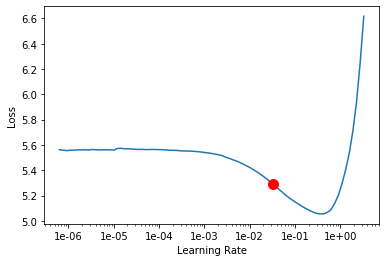

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [0]:
torch.cuda.empty_cache()
!nvidia-smi

Mon Dec 16 00:54:18 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    32W / 250W |  15463MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
learn.fit_one_cycle(1, min_grad_lr,callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy',name='lm_head_2')])

epoch,train_loss,valid_loss,accuracy,time
0,3.882864,3.743563,0.305953,02:56


Better model found at epoch 0 with accuracy value: 0.30595314502716064.


In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-06
Min loss divided by 10: 1.10E-07


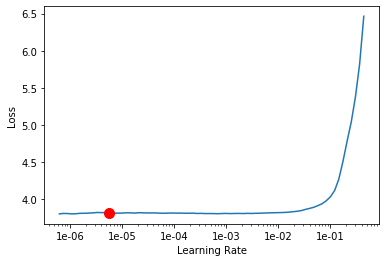

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(10, min_grad_lr/10,callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy',name='lm_tuned_2')],moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.634318,3.633884,0.318825,03:34
1,3.549066,3.560119,0.327664,03:34
2,3.466143,3.530603,0.330746,03:34
3,3.351593,3.470211,0.338382,03:34
4,3.244215,3.457908,0.342353,03:33
5,3.124940,3.455197,0.344507,03:34
6,2.994901,3.461791,0.346603,03:34
7,2.882187,3.476959,0.347816,03:34
8,2.798603,3.493335,0.348026,03:33
9,2.750403,3.503644,0.347797,03:34


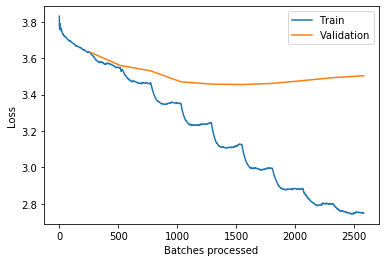

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.load("lm_tuned_2_5")

In [0]:
learn.validate()

[3.4539843, tensor(0.3446)]

In [0]:
#Test of lm
learn.predict("", n_words=10)

' Hold onto it your way . xxbos i have'

In [0]:
learn.save_encoder('lstm_lm_enc_1')

In [0]:
if(is_overall):
    learn = text_classifier_learner(overall_clas, AWD_LSTM,config=arch_clas_config,pretrained=not qrnn,drop_mult=0.3).to_fp16()
else:
    learn = text_classifier_learner(clas, AWD_LSTM,config=arch_clas_config,pretrained=not qrnn,drop_mult=0.3).to_fp16()
learn.load_encoder('lstm_lm_enc_1')



FileNotFoundError: ignored

In [0]:
f_beta = MultiLabelFbeta(beta=1,thresh=0.5)
precision=Precision(average='micro')

recall=Recall(average='micro')


#Does not work with precision and recall; probably due to them being for binary problems
learn.metrics=[accuracy,accuracy_thresh,f_beta]

In [0]:

if(is_overall):
    overall_clas.show_batch()
else:
    clas.show_batch()

text,target
"xxbos no , i 'm still a student and everything is expensive and time - consuming . and my parents wo n't acknowledge any feelings of xxunk for anything . the last time i truly enjoyed something was over three years ago . i used to collect xxunk / merch and loved watching anime . i was a huge fucking xxunk basically so i went to xxunk cons and stuff",emotional_disclosure;information_disclosure
"xxbos xxmaj unfortunately , it has been removed for the following reason : > xxmaj this submission has been abandoned by the submitter . > > xxmaj we 're here to talk , we do n't want the submitter to make a thread and completely ignore it » > > xxmaj the submitter is required to reply to any top comment within the first 3 hours . > > xxmaj",
"xxbos i ca n't vouch for every other state in the xxmaj union , but my understanding is that alimony laws were created to protect women ( because in the xxunk it was n't acceptable for married women to be working , but when her husband divorced her she 'd be left destitute because she might not even have a high school diploma and would have no marketable skills to",emotional_disclosure;information_disclosure
"xxbos i would guess that it 's probably because men are probably more likely to download and play phone games already , so it 's not only a ploy to get more women to download their game , but also play on competitive nature and basically telling guys , "" you 're gon na suck at this game "" so they 're like "" xxunk uh "" and download it",
"xxbos xxmaj how many kids do you want : 1 or 2 , maybe 3 if i feel like adopting xxmaj do you want any pets : xxmaj yes , jumping spiders , tarantulas , xxunk , snakes , bearded dragons , and / or cats xxmaj do you want to change your name : xxmaj as much as i do n't like my name , no .",emotional_disclosure;information_disclosure


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03
Min loss divided by 10: 3.02E-02


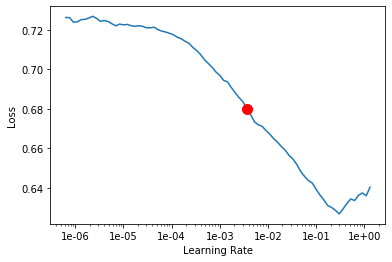

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [0]:
learn.fit_one_cycle(1, min_grad_lr,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,accuracy_thresh,multi_label_fbeta,time
0,0.593344,0.564330,0.387485,0.729693,0.804771,00:03


In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), callbacks=[SaveModelCallback(learn, every='improvement', monitor='multi_label_fbeta')],moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,accuracy_thresh,multi_label_fbeta,time
0,0.536527,0.525068,0.378546,0.731442,0.780368,00:03


Better model found at epoch 0 with multi_label_fbeta value: 0.7803675532341003.


In [0]:
learn.save('second_1')
learn.load('second_1');
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,accuracy_thresh,multi_label_fbeta,time
0,0.489464,0.513990,0.386708,0.739798,0.777307,00:04


In [0]:
learn.save('third_1')

In [0]:
learn.load('third_1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.63E-04


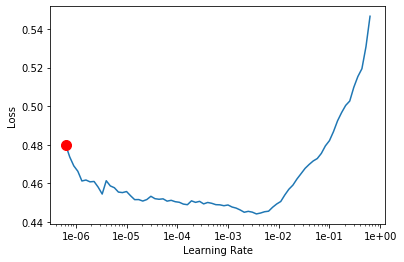

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [0]:


learn.unfreeze()
learn.fit_one_cycle(2, slice(5e-4/(2.6**4),5e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,accuracy_thresh,multi_label_fbeta,time
0,0.446236,0.516472,0.385931,0.739992,0.772645,00:06
1,0.438729,0.518870,0.386708,0.738438,0.767620,00:06


In [0]:
learn.save("trained_classifier_1")

In [0]:
learn.load("trained_classifier")

In [0]:
learn.validate()

[0.5472161]

In [0]:
#@title panel
preds,t_labels = learn.get_preds()
preds,t_labels = preds.numpy(),t_labels.numpy()
thresh = 0.5 #@param
preds[preds >= thresh]=1
preds[preds < thresh]=0
print(classification_report(t_labels,preds,target_names=overall_categories,digits=5))
print(accuracy_score(t_labels,preds))

              precision    recall  f1-score   support

     support    0.67552   0.33578   0.44858       682
  disclosive    0.67643   0.69581   0.68598      1361

   micro avg    0.67625   0.57562   0.62189      2043
   macro avg    0.67597   0.51579   0.56728      2043
weighted avg    0.67612   0.57562   0.60673      2043
 samples avg    0.43121   0.40770   0.41340      2043

0.5235134084726001


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
learn.predict("You will find someone better!")

(MultiCategory support, tensor([1., 0.]), tensor([0.8787, 0.4194]))